<a href="https://colab.research.google.com/github/HakureiPOI/Modeling_Allowance/blob/main/NeuralNetworkOptimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [2]:
sns.set_style("whitegrid")

In [3]:
class NeuralNetworkOptimizer():
    def __init__(self, target_function, input_dim, bounds, hidden_layers=[128, 128], lr=0.01, num_samples=4000, epochs=2000, optimize_steps=200, optimize_lr=0.1, early_stop_patience=10):
        """
        使用神经网络作为代理模型来优化目标函数的类

        参数：
        - target_function: 可调用对象，需要优化的目标函数
        - input_dim: int，输入的维度
        - bounds: 列表，每个维度的边界 [(min1, max1), (min2, max2), ...]
        - hidden_layers: 列表，隐藏层的每层神经元数量
        - lr: float，训练代理模型的初始学习率
        - num_samples: int，用于训练的样本数量
        - epochs: int，训练代理模型的最大迭代次数
        - optimize_steps: int，优化代理模型的迭代次数
        - optimize_lr: float，优化代理模型的学习率
        - early_stop_patience: int，早停策略的容忍次数
        """
        self.target_function = target_function
        self.input_dim = input_dim
        self.bounds = bounds
        self.hidden_layers = hidden_layers
        self.lr = lr
        self.num_samples = num_samples
        self.epochs = epochs
        self.optimize_steps = optimize_steps
        self.optimize_lr = optimize_lr
        self.early_stop_patience = early_stop_patience

        self.scaler = StandardScaler()

        self.model = self._build_model()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, 'min', patience=5, factor=0.5)
        self.loss_fn = nn.MSELoss()

        # 用于可视化训练和优化过程
        self.loss_history = []
        self.optimization_history = []

        self.optimized_x = None

    def _build_model(self):
        """构建神经网络模型"""
        layers = []
        input_dim = self.input_dim
        for hidden_dim in self.hidden_layers:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())
            input_dim = hidden_dim
        layers.append(nn.Linear(input_dim, 1))
        return nn.Sequential(*layers)

    def _generate_data(self):
        """根据边界生成随机训练数据"""
        x_data = np.random.uniform(
            [b[0] for b in self.bounds],
            [b[1] for b in self.bounds],
            (self.num_samples, self.input_dim)
        )
        y_data = np.array([self.target_function(x) for x in x_data])
        # 数据标准化
        x_data = self.scaler.fit_transform(x_data)
        return torch.tensor(x_data, dtype=torch.float32), torch.tensor(y_data, dtype=torch.float32).unsqueeze(1)

    def train_model(self):
        """训练代理模型，添加早停逻辑和动态学习率调整"""
        x_train, y_train = self._generate_data()
        best_loss = float('inf')
        patience_counter = 0

        for epoch in range(self.epochs):
            self.optimizer.zero_grad()
            predictions = self.model(x_train)
            loss = self.loss_fn(predictions, y_train)
            loss.backward()
            self.optimizer.step()

            self.scheduler.step(loss)

            self.loss_history.append(loss.item())

            if loss.item() < best_loss:
                best_loss = loss.item()
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= self.early_stop_patience:
                print(f"Early stopping at epoch {epoch}, Loss: {best_loss}")
                break

            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {loss.item()}")

    def visualize_training(self):
        """可视化训练过程中的损失变化"""
        plt.figure(figsize=(10, 6))
        plt.plot(self.loss_history, label="Training Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training Loss Over Epochs")
        plt.legend()
        plt.show()

    def optimize(self):
        """使用代理模型优化目标函数"""
        x_opt = torch.randn(self.input_dim, requires_grad=True)  # 初始猜测
        opt_optimizer = torch.optim.Adam([x_opt], lr=self.optimize_lr)

        for step in range(self.optimize_steps):
            opt_optimizer.zero_grad()
            pred_loss = self.model(x_opt.unsqueeze(0))  # 使用代理模型
            pred_loss.backward()
            opt_optimizer.step()

            self.optimization_history.append(pred_loss.item())
            if step % 20 == 0:
                print(f"Step {step}, Surrogate Loss: {pred_loss.item()}")

        optimized_x = x_opt.detach().numpy()
        real_value = self.target_function(self.scaler.inverse_transform(optimized_x.reshape(1, -1))[0])
        print(f"优化后的 x: {self.scaler.inverse_transform(optimized_x.reshape(1, -1))[0]}")
        print(f"优化后的目标函数值: {real_value}")

        self.optimized_x = optimized_x

    def visualize_optimization(self):
        """可视化优化过程中的损失变化"""
        plt.figure(figsize=(10, 6))
        plt.plot(self.optimization_history, label="Optimization Loss")
        plt.xlabel("Step")
        plt.ylabel("Loss")
        plt.title("Optimization Loss Over Steps")
        plt.legend()
        plt.show()

    def run(self):
        """执行整个训练和优化过程"""
        print("正在训练代理模型...")
        self.train_model()
        self.visualize_training()
        print("正在优化目标函数...")
        self.optimize()
        self.visualize_optimization()


In [4]:
def example_function(x):
    x = np.array(x)
    A = 10
    return A * len(x) + np.sum(x**2 - A * np.cos(2 * np.pi * x))

In [5]:
bounds = [(-5, 5)] * 5
optimizer = NeuralNetworkOptimizer(
    target_function=example_function,
    input_dim=5,
    bounds=bounds,
    hidden_layers=[64, 64],
    lr=0.01,
    num_samples=1000,
    epochs=1000,
    optimize_steps=200,
    optimize_lr=0.1,
    early_stop_patience=10
)

正在训练代理模型...
Epoch 0, Loss: 8956.1435546875
Early stopping at epoch 33, Loss: 448.0113525390625


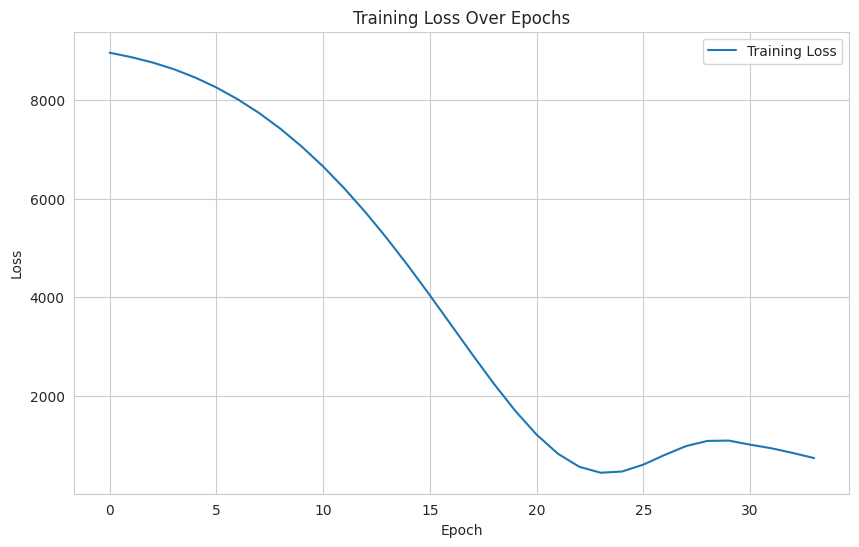

正在优化目标函数...
Step 0, Surrogate Loss: 132.625732421875
Step 20, Surrogate Loss: 49.95210266113281
Step 40, Surrogate Loss: 48.85541534423828
Step 60, Surrogate Loss: 48.66497802734375
Step 80, Surrogate Loss: 48.602012634277344
Step 100, Surrogate Loss: 48.589359283447266
Step 120, Surrogate Loss: 48.598915100097656
Step 140, Surrogate Loss: 48.59223556518555
Step 160, Surrogate Loss: 48.590782165527344
Step 180, Surrogate Loss: 48.592124938964844
优化后的 x: [ 0.15188842 -0.30182    -0.32728776  0.24995102 -0.10143939]
优化后的目标函数值: 44.33907508850098


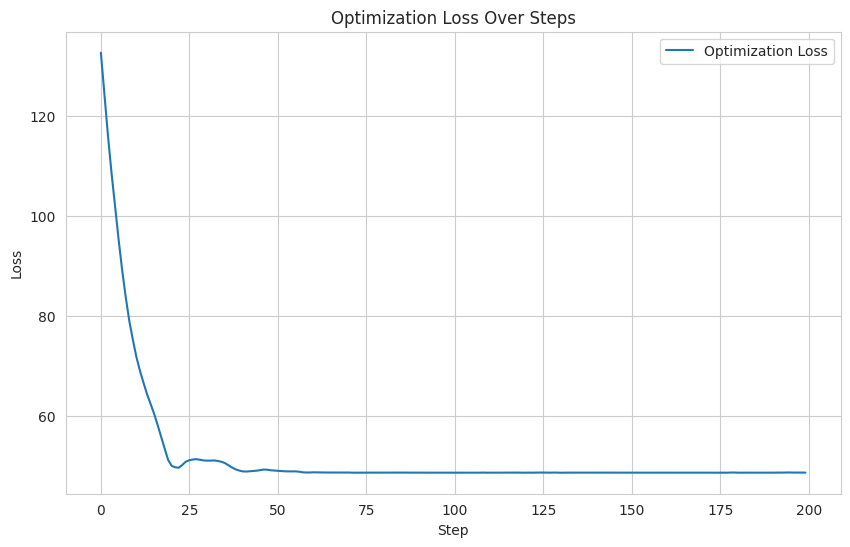

In [6]:
optimizer.run()